## Example Data

In [1]:
# A dictionary of movie critics and their ratings of a small # set of movies
critics={'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5, 'Just My Luck': 3.0, 'Superman Returns': 3.5, 'You, Me and Dupree': 2.5, 'The Night Listener': 3.0},
'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5, 'Just My Luck': 1.5, 'Superman Returns': 5.0, 'The Night Listener': 3.0, 'You, Me and Dupree': 3.5},
'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0, 'Superman Returns': 3.5, 'The Night Listener': 4.0}, 'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0, 'The Night Listener': 4.5, 'Superman Returns': 4.0, 'You, Me and Dupree': 2.5},
'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0, 'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0, 'You, Me and Dupree': 2.0},
'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0, 'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5}, 'Toby': {'Snakes on a Plane':4.5,'You, Me and Dupree':1.0,'Superman Returns':4.0}}

In [2]:
critics['Lisa Rose']['Lady in the Water']

2.5

In [3]:
from math import sqrt
from collections import defaultdict

## Euclidean distance similarity  
We can calculate by euclidean distance.  
After get the distance, we take 1/(1+dist).  
So we get similarity between (0, 1], if sim == 1, then the points are duplicated.  
If the distance is big, then the sim is small.


In [24]:
# Return a distance based similarity score for person1 and person2
def sim_distance(prefs, person1, person2):
    #get shared item
    shared_items = []
    for item in prefs[person1]:
        if item in prefs[person2]:
            shared_items.append(item)
    
    #if no shared items, return 0 (no similarity)
    if len(shared_items) == 0: return 0
    
    #Calculate Euclidean distance
    sum_of_squares = sum(pow(prefs[person1][item] - prefs[person2][item], 2) 
                         for item in shared_items)
    distance = sum_of_squares ** 0.5
    
    return 1/(1+distance) # Revise from the book which calculate just by sum of suqares

In [25]:
sim_distance(critics, 'Lisa Rose', 'Gene Seymour')

0.14814814814814814

In [6]:
sim_distance(critics, 'Lisa Rose', 'Michael Phillips')

0.4721359549995794

## Pearson Correlation Score  
The code from the book is a little wired, so I rewrite the pearson calculation by this equation.  
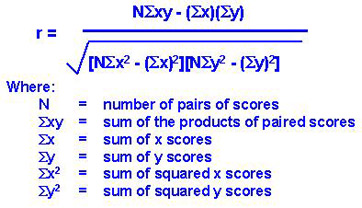

In [7]:
# Returns the Pearson correlation coefficient for p1 and p2
def sim_pearson(prefs, person1, person2):
    #get shared items
    shared_items = []
    person1_pref = prefs[person1]
    person2_pref = prefs[person2]
    for item in person1_pref:
        if item in person2_pref:
            shared_items.append(item)
    #if no shared items, return 0 (no similarity)
    if len(shared_items) == 0: return 0
    
    # Get needed parameters
    n = len(shared_items)
    sum_xy = sum([person1_pref[item]*person2_pref[item] for item in shared_items])
    sum_x = sum([person1_pref[item] for item in shared_items])
    sum_y = sum([person2_pref[item] for item in shared_items])
    sum_x2 = sum([person1_pref[item]**2 for item in shared_items])
    sum_y2 = sum([person2_pref[item]**2 for item in shared_items])
    
    numerator = n*sum_xy - sum_x*sum_y
    denominator = sqrt((n*sum_x2 - sum_x**2) * (n*sum_y2 - sum_y**2))
    if denominator==0: return 0
    return numerator / denominator

In [8]:
sim_pearson(critics, 'Lisa Rose', 'Gene Seymour')

0.39605901719066977

In [9]:
sim_pearson(critics, 'Lisa Rose', 'Michael Phillips') 
# We can find actually the peason correlation between ('Lisa Rose', 'Gene Seymour') and ('Lisa Rose', 'Michael Phillips') is not so different

0.40451991747794525

## Ranking the critics  
After we get similarity, we can rank the things based on similarity.

In [10]:
# Return the top n matches for a person from the prefs
def top_matches(prefs, person, n=5, similarity=sim_pearson):
    scores = [(other, similarity(prefs, person, other)) 
                for other in prefs if other != person]
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:n]

In [11]:
print(top_matches(critics, 'Toby')) # return the top 5 similar people

[('Lisa Rose', 0.9912407071619304), ('Mick LaSalle', 0.924473451641905), ('Claudia Puig', 0.8934051474415642), ('Jack Matthews', 0.6628489803598702), ('Gene Seymour', 0.3812464258315117)]


## Add weights  
Because there are no weights for each critic, so we will get strange result some time.  
We need add the weight calculation process like below.  
![](https://i.loli.net/2019/02/27/5c76877625c3a.png)

In [48]:
# Get top n recommendations for a person by using a weighted average of every others rangking
def get_recommend(prefs, person, n=5, similarity=sim_pearson):
    total = defaultdict(int)
    sim_sum = defaultdict(int)
    for other in prefs:
        if other == person: continue
        sim = similarity(prefs, person, other)
        
        # ignore zero and minus score
        if sim<0 : continue
        # Calculate weight item
        for item in prefs[other]:
            # only calculate unseen item 
            if (item not in prefs[person] or prefs[person][item]==0):
                total[item] += prefs[other][item]*sim
                sim_sum[item] += sim

    # total / simsum
    rankings = [(item, total[item] / (sim_sum[item])) for item in total if total[item]!=0] # I find there are some 0 entry just clean it
    rankings.sort(key=lambda x: x[1], reverse=True)
    return rankings[:n]

In [13]:
get_recommend(critics, 'Toby')

[('The Night Listener', 3.3477895267131013),
 ('Lady in the Water', 2.8325499182641622),
 ('Just My Luck', 2.5309807037655645)]

In [14]:
get_recommend(critics, 'Toby', similarity=sim_distance)

[('The Night Listener', 3.457128694491423),
 ('Lady in the Water', 2.778584003814924),
 ('Just My Luck', 2.4224820423619167)]

## Matching similar pruducts  
It's just like matching the similar person.  
The only thing we need to do is reverse the person to product dictionary.

In [15]:
def transform_prefs(prefs):
    results = defaultdict(dict)
    for person in prefs:
        for item in prefs[person]:
            results[item][person] = prefs[person][item]
    return results

In [16]:
products = transform_prefs(critics)

In [17]:
top_matches(products, "Superman Returns")

[('You, Me and Dupree', 0.657951694959769),
 ('Lady in the Water', 0.4879500364742666),
 ('Snakes on a Plane', 0.11180339887498948),
 ('The Night Listener', -0.1798471947990542),
 ('Just My Luck', -0.42289003161103106)]

In [18]:
get_recommend(products, 'Just My Luck')

[('Michael Phillips', 4.0), ('Jack Matthews', 3.0)]

## Real Recommender
In the book, we use del.icio.us API.  
However, because we can not access that website now, so we just use MovieLens data for the rest example.  
So you can skip the "Building Dataset" section and use later code to load data.

In [19]:
def loadMovieLens(path='./data/ml-100k'):
    # Get movie titles
    movies={}
    for line in open(path+'/u.item', 'r'):
        (id,title)=line.split('|')[0:2]
        movies[id]=title
  
    # Load data
    prefs={}
    for line in open(path+'/u.data', 'r'):
        (user,movieid,rating,ts)=line.split('\t')
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]] = float(rating)
    return prefs

In [20]:
prefs = loadMovieLens()

In [40]:
prefs['87']

{'2001: A Space Odyssey (1968)': 5.0,
 'Ace Ventura: Pet Detective (1994)': 4.0,
 'Addams Family Values (1993)': 2.0,
 'Addicted to Love (1997)': 4.0,
 'Adventures of Priscilla, Queen of the Desert, The (1994)': 3.0,
 'Adventures of Robin Hood, The (1938)': 5.0,
 'Air Force One (1997)': 3.0,
 'Air Up There, The (1994)': 3.0,
 'Alien (1979)': 4.0,
 'American President, The (1995)': 5.0,
 'Annie Hall (1977)': 4.0,
 'Apocalypse Now (1979)': 4.0,
 'Babe (1995)': 5.0,
 'Baby-Sitters Club, The (1995)': 2.0,
 'Back to the Future (1985)': 5.0,
 'Bad Boys (1995)': 4.0,
 'Bananas (1971)': 5.0,
 'Barcelona (1994)': 3.0,
 'Batman & Robin (1997)': 4.0,
 'Batman (1989)': 3.0,
 'Batman Returns (1992)': 3.0,
 'Big Green, The (1995)': 3.0,
 'Big Squeeze, The (1996)': 2.0,
 'Birdcage, The (1996)': 4.0,
 'Blade Runner (1982)': 4.0,
 'Blues Brothers, The (1980)': 5.0,
 'Boomerang (1992)': 3.0,
 'Boot, Das (1981)': 4.0,
 'Brady Bunch Movie, The (1995)': 2.0,
 'Braveheart (1995)': 4.0,
 'Bridge on the River

In [21]:
import random 
user = random.choice(list(prefs.keys()))
print(user)

482


In [22]:
top_matches(prefs, user)

[('718', 1.0), ('336', 1.0), ('900', 1.0), ('237', 1.0), ('614', 1.0)]

In [49]:
get_recommend(prefs, '87', n=30)

[('They Made Me a Criminal (1939)', 5.0),
 ('Saint of Fort Washington, The (1993)', 5.0),
 ('Entertaining Angels: The Dorothy Day Story (1996)', 5.0),
 ('Marlene Dietrich: Shadow and Light (1996) ', 5.0),
 ('Star Kid (1997)', 5.0),
 ('Great Day in Harlem, A (1994)', 5.0),
 ('Boys, Les (1997)', 5.0),
 ('Santa with Muscles (1996)', 5.0),
 ('Legal Deceit (1997)', 4.898844431289231),
 ('Letter From Death Row, A (1998)', 4.815019082242706),
 ('Hearts and Minds (1996)', 4.732108298394142),
 ('Pather Panchali (1955)', 4.696244466490867),
 ('Lamerica (1994)', 4.652397061026759),
 ('Leading Man, The (1996)', 4.538723693474813),
 ('Mrs. Dalloway (1997)', 4.535081339106105),
 ('Innocents, The (1961)', 4.532337612572983),
 ('Casablanca (1942)', 4.527998574747079),
 ('Everest (1998)', 4.5102701497198625),
 ('Dangerous Beauty (1998)', 4.4939677554284385),
 ('Wallace & Gromit: The Best of Aardman Animation (1996)', 4.485151301801345),
 ('Wrong Trousers, The (1993)', 4.463287461290222),
 ('Kaspar Haus

In [53]:
from tqdm import tqdm

## Item based approach
If there are so many users, then we calculate all similarity and recommend items is unefficient.  
So we can build item similarity dict first, and use it later.

In [57]:
def calc_similar_items(prefs, n=10, similarity=sim_distance):
    # Search for the top n mosts similar items
    results = {}
    item_prefs = transform_prefs(prefs)
    for item in tqdm(item_prefs):
        results[item] = top_matches(item_prefs, item, n=n, similarity=similarity)
    return results

In [58]:
itemsim = calc_similar_items(prefs)

100%|██████████| 1664/1664 [00:31<00:00, 53.62it/s]


In [61]:
moviesim = calc_similar_items(critics)

100%|██████████| 6/6 [00:00<00:00, 7351.98it/s]


In [64]:
def get_recommend_item(prefs, item_match, user):
    user_pref = prefs[user]
    scores = defaultdict(int)
    total_sim = defaultdict(int)
    
    for item,rate in user_pref.items():
        for (item2, similarity) in item_match[item]:
            if item2 in user_pref: continue
            total_sim[item2] += similarity
            scores[item2] += similarity * rate
    ranking = [(item, scores[item]/total_sim[item]) for item in total_sim if total_sim[item]!=0]
    ranking.sort(key=lambda x: x[1], reverse=True)
    return ranking

In [65]:
get_recommend_item(critics, moviesim, 'Toby')

[('The Night Listener', 3.182634730538922),
 ('Just My Luck', 2.5983318700614575),
 ('Lady in the Water', 2.4730878186968837)]

In [66]:
# Try movie lens
get_recommend_item(prefs, itemsim, '87')

[('Spice World (1997)', 5.0),
 ('Night Flier (1997)', 5.0),
 ('Amadeus (1984)', 5.0),
 ('Hear My Song (1991)', 5.0),
 ('Temptress Moon (Feng Yue) (1996)', 5.0),
 ('Mondo (1996)', 5.0),
 ('So Dear to My Heart (1949)', 5.0),
 ('Conspiracy Theory (1997)', 5.0),
 ('Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)',
  5.0),
 ('Golden Earrings (1947)', 5.0),
 ('Fly Away Home (1996)', 5.0),
 ('Underneath, The (1995)', 5.0),
 ('Letter From Death Row, A (1998)', 5.0),
 ('Everest (1998)', 5.0),
 ('Shiloh (1997)', 5.0),
 ('An Unforgettable Summer (1994)', 5.0),
 ('Condition Red (1995)', 5.0),
 ('Scarlet Letter, The (1926)', 4.75),
 ("Someone Else's America (1995)", 4.666666666666667),
 ('Anna (1996)', 4.666666666666667),
 ('Last Klezmer: Leopold Kozlowski, His Life and Music, The (1995)',
  4.666666666666667),
 ('They Made Me a Criminal (1939)', 4.555555555555555),
 ('Lady of Burlesque (1943)', 4.523809523809524),
 ('Legal Deceit (1997)', 4.5),
 ('Collectionneuse,

## User-based or Item-based filtering
We need consider about whether dense or sparse about the dataset.  
Usually item-based is better on sparse dataset.

## Excersises 
1. **Tanimoto score**. Find out what a Tanimoto similarity score is. In what cases could this be used as the similarity metric instead of Euclidean distance or Pearson coefficient? Create a new similarity function using the Tanimoto score.  
2. **Tag similarity**. Using the del.icio.us API, create a dataset of tags and items. Use this to calculate similarity between tags and see if you can find any that are almost identical. Find some items that could have been tagged “programming” but were not.  
3. **User-based efficiency**. The user-based filtering algorithm is inefficient because it compares a user to all other users every time a recommendation is needed. Write a function to precompute user similarities, and alter the recommendation code to use only the top five other users to get recommendations.  
4. **Item-based bookmark filtering**. Download a set of data from del.icio.us and add it to the database. Create an item-item table and use this to make item-based recommendations for various users. How do these compare to the user-based recommendations?  
5. **Audioscrobbler**. Take a look at http://www.audioscrobbler.net, a dataset containing music preferences for a large set of users. Use their web services API to get a set of data for making and building a music recommendation system.

### Tanimoto Coefficient
The Tanimoto coefficient between two points, a and b, with k dimensions is calculated as:

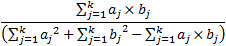

The Tanimoto similarity is only applicable for a binary variable, and for binary variables the Tanimoto coefficient ranges from 0 to +1 (where +1 is the highest similarity)

In [67]:
# 1. tanimoto score, for binary attributes vectors
def sim_tanimoto(prefs, person1, person2):
    #get shared items
    shared_items = []
    person1_pref = prefs[person1]
    person2_pref = prefs[person2]
    for item in person1_pref:
        if item in person2_pref:
            shared_items.append(item)
    #if no shared items, return 0 (no similarity)
    if len(shared_items) == 0: return 0

    # Necessary terms
    sum_ab = sum(person1_pref[item]*person2_pref[item] for item in shared_items)
    sum_a2 = sum(person1_pref[item]**2 for item in shared_items)
    sum_b2 = sum(person2_pref[item]**2 for item in shared_items)
    score = sum_ab / (sum_a2 + sum_b2 - sum_ab)
    return score

### Tanimoto Coefficient
he user-based filtering algorithm is inefficient because it compares a user to all other users every time a recommendation is needed. Write a function to precompute user similarities, and alter the recommendation code to use only the top five other users to get recommendations.  
- Function to calculate the precompute user similarities;  
- Rewrite the user based function.